## Compare krill distributions

In [301]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

##### Load data

In [302]:
# load krillpodym and krillbase data formated
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/')

krill_base = pd.read_csv('./outputs_formated_data/Krill_density_krillbase_df_final.csv').rename(columns = {'LONGITUDE_largegrid' : 'longitude' , 'LATITUDE_largegrid' : 'latitude'})[['latitude', 'longitude', 'STANDARDISED_KRILL_UNDER_1M2_log']]
krill_podym = pd.read_csv('./outputs_formated_data/Krill_biomass_df_final.csv')[['latitude', 'longitude', 'krill_adult_log']]

In [303]:
krill_base = krill_base.dropna()#[krill_base['STANDARDISED_KRILL_UNDER_1M2_log'] != 0]
krill_base.set_index(['latitude', 'longitude'], inplace = True) # 1063  

krill_podym = krill_podym.dropna()
krill_podym = krill_podym[krill_podym['krill_adult_log'] != 0] # remove 0 bc Nan of krillbase are 0 of krillpodym
krill_podym.set_index(['latitude', 'longitude'], inplace = True) # 1648  

# Compare the spatial ranges of KRILLPODYM and KRILLBASE

In [284]:
krill_range = pd.merge(krill_podym.reset_index(), krill_base.reset_index(), on = ['latitude',	'longitude'], how='outer', indicator = True)
krill_range.set_index(['latitude',	'longitude'], inplace = True)

krill_range.rename(columns={'_merge': 'label'}, inplace=True)
krill_range['label'] = krill_range['label'].replace({
    'left_only': 1, # krillpoydm only  
    'right_only': 2, # krillbase only
    'both': 3}) # in both


krill_range

krill_adult_log  STANDARDISED_KRILL_UNDER_1M2_log label
latitude longitude                                                         
-77      -179               0.57452                               NaN     1
         -177               0.81818                               NaN     1
         -175               1.00264                               NaN     1
         -173               0.99747                               NaN     1
         -171               1.14972                               NaN     1
...                             ...                               ...   ...
-51       87                    NaN                               0.0     2
-73       179                   NaN                               0.0     2
-71       179                   NaN                               0.0     2
-67       179                   NaN                               0.0     2
-61       179                   NaN                               0.0     2

[1905 rows x 3 columns]

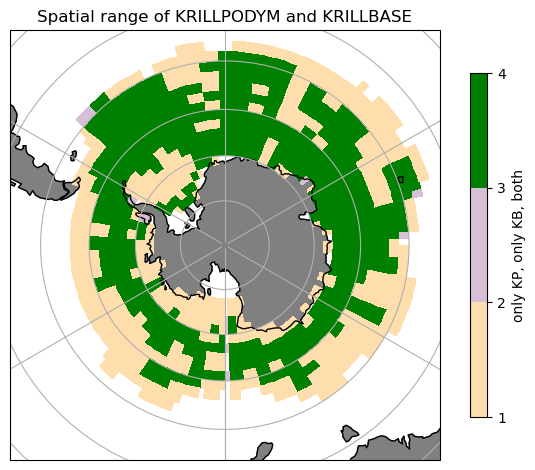

In [285]:
krill_range_xarray = xr.Dataset.from_dataframe(krill_range)
krill_range_xarray

map_proj = ccrs.SouthPolarStereo()

p = krill_range_xarray["label"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels = [1, 2, 3, 4],
    colors = ['navajowhite', 'thistle', 'green']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'only KP, only KB, both', shrink = 0.8)
plt.title('Spatial range of KRILLPODYM and KRILLBASE')

plt.tight_layout()

# plt.savefig('./figures/spatial_range_KP_KB.png', bbox_inches = 'tight', dpi=300)

plt.show()


# Comparision over the shared area of between KRILLBASE and KRILLPODYM 

### First crop the KRILLPODYM dataset onto the space range of KRILLBASE so we compare them on the same range
I.e., same number of cells, so same definition of the quantiles

In [286]:
krill_common_range = krill_base.merge(krill_podym, how='inner', left_index=True, right_index=True)
krill_common_range

,,STANDARDISED_KRILL_UNDER_1M2_log,krill_adult_log
latitude,longitude,,
-69,-179,0.000000,1.54654
-67,-179,0.000000,1.60825
-61,-179,1.355432,1.03334
-69,-177,0.000000,1.54440
-67,-177,0.000000,1.54895
...,...,...,...
-71,177,0.000000,1.44382
-67,177,1.645766,1.38528
-65,177,0.101403,1.35487


In [287]:
krill_podym_quantiles = krill_common_range['krill_adult_log'].quantile(q=[0.3333, 0.6666])
krill_base_quantiles = krill_common_range['STANDARDISED_KRILL_UNDER_1M2_log'].quantile(q=[0.3333, 0.6666])
display(krill_podym_quantiles2)
display(krill_base_quantiles2)

0.3333    1.226229
0.6666    1.638561
Name: krill_adult_log, dtype: float64

0.3333    0.022325
0.6666    0.691999
Name: STANDARDISED_KRILL_UNDER_1M2_log, dtype: float64

In [288]:
krill_common_range['UpTiertile_P'] = np.where(krill_common_range['krill_adult_log'] > krill_podym_quantiles.iloc[1], 1, 0)
krill_common_range['UpTiertile_B'] = np.where(krill_common_range['STANDARDISED_KRILL_UNDER_1M2_log'] > krill_base_quantiles.iloc[1], 1, 0)
krill_common_range

,,STANDARDISED_KRILL_UNDER_1M2_log,krill_adult_log,UpTiertile_P,UpTiertile_B
latitude,longitude,,,,
-69,-179,0.000000,1.54654,0,0
-67,-179,0.000000,1.60825,0,0
-61,-179,1.355432,1.03334,0,1
-69,-177,0.000000,1.54440,0,0
-67,-177,0.000000,1.54895,0,0
...,...,...,...,...,...
-71,177,0.000000,1.44382,0,0
-67,177,1.645766,1.38528,0,1
-65,177,0.101403,1.35487,0,0


In [289]:
krill_common_range_xarray = xr.Dataset.from_dataframe(krill_common_range)
krill_common_range_xarray

<xarray.Dataset>
Dimensions:                           (latitude: 16, longitude: 179)
Coordinates:
  * latitude                          (latitude) int64 -77 -75 -73 ... -49 -47
  * longitude                         (longitude) int64 -179 -177 ... 175 177
Data variables:
    STANDARDISED_KRILL_UNDER_1M2_log  (latitude, longitude) float64 nan ... nan
    krill_adult_log                   (latitude, longitude) float64 nan ... nan
    UpTiertile_P                      (latitude, longitude) float64 nan ... nan
    UpTiertile_B                      (latitude, longitude) float64 nan ... nan

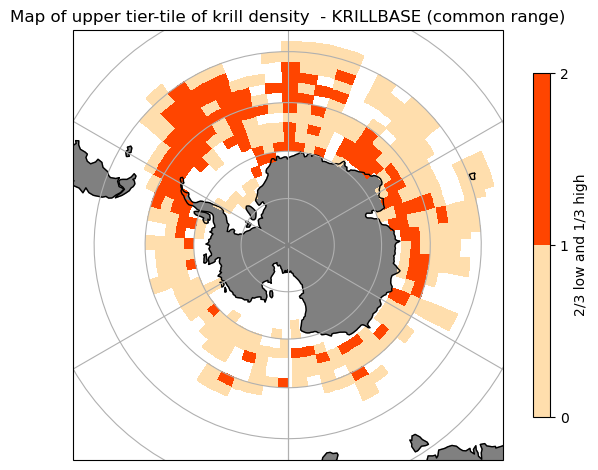

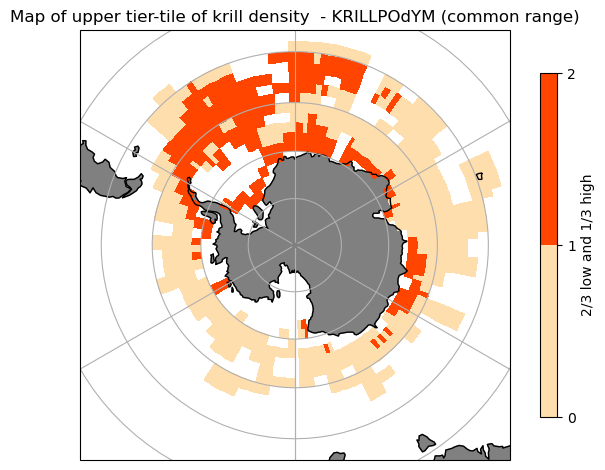

In [290]:
map_proj = ccrs.SouthPolarStereo()

p = krill_common_range_xarray["UpTiertile_B"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels = [0,1,2],
    colors = ['navajowhite', 'orangered']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = '2/3 low and 1/3 high', shrink = 0.8)
plt.title('Map of upper tier-tile of krill density  - KRILLBASE (common range)')
plt.tight_layout()
plt.show()

map_proj = ccrs.SouthPolarStereo()

p = krill_common_range_xarray["UpTiertile_P"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels = [0, 1,2],
    colors = ['navajowhite', 'orangered']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = '2/3 low and 1/3 high', shrink = 0.8)
plt.title('Map of upper tier-tile of krill density  - KRILLPOdYM (common range)')
plt.tight_layout()

# plt.savefig('./figures/upper_tiertile_KP_common_range.png', bbox_inches = 'tight', dpi=300)

plt.show()


### Categrories

In [291]:
conditions = [
    (krill_common_range["UpTiertile_P"] == 1) & (krill_common_range["UpTiertile_B"] == 1),
    (krill_common_range["UpTiertile_P"] == 0) & (krill_common_range["UpTiertile_B"] == 0),
    
    (krill_common_range["UpTiertile_P"] == 0) & (krill_common_range["UpTiertile_B"] == 1),
    (krill_common_range["UpTiertile_P"] == 1) & (krill_common_range["UpTiertile_B"] == 0),

    (krill_common_range["UpTiertile_P"] == 1) & (krill_common_range["UpTiertile_B"].isna()),
    (krill_common_range["UpTiertile_P"] == 0) & (krill_common_range["UpTiertile_B"].isna()),

    (krill_common_range["UpTiertile_P"].isna()) & (krill_common_range["UpTiertile_B"] == 1),
    (krill_common_range["UpTiertile_P"].isna()) & (krill_common_range["UpTiertile_B"] == 0),

]

values = ["1", "2", 
          "3", "4",
         "5", "6",
         "7", "8"]

values_cat = ["Accordance_High_krill", "Accordance_low_krill", 
          "Discordance_UB", "Discordance_UP",
         "No_data_KB_highkrill", "No_data_KB_low_krill",
         "No_data_KP_highkrill", "No_data_KP_lowkrill"]


In [292]:
krill_common_range['concordance_type'] = np.select(conditions, values_cat)
krill_common_range['concordance_type_nb'] = np.select(conditions, values)

krill_common_range["concordance_type_nb"] = pd.to_numeric(krill_common_range["concordance_type_nb"])


conditions = [
    (krill_common_range['concordance_type'] == "Accordance_High_krill") | (krill_common_range['concordance_type'] == "Accordance_low_krill"),
    (krill_common_range['concordance_type'] == "Discordance_UP") | (krill_common_range['concordance_type'] == "Discordance_UB")
]

values = [1, 0]

krill_common_range['concordance_yes_no'] = np.select(conditions, values, default=np.NaN)
krill_common_range

,,STANDARDISED_KRILL_UNDER_1M2_log,krill_adult_log,UpTiertile_P,UpTiertile_B,concordance_type,concordance_type_nb,concordance_yes_no
latitude,longitude,,,,,,,
-69,-179,0.000000,1.54654,0,0,Accordance_low_krill,2,1.0
-67,-179,0.000000,1.60825,0,0,Accordance_low_krill,2,1.0
-61,-179,1.355432,1.03334,0,1,Discordance_UB,3,0.0
-69,-177,0.000000,1.54440,0,0,Accordance_low_krill,2,1.0
-67,-177,0.000000,1.54895,0,0,Accordance_low_krill,2,1.0
...,...,...,...,...,...,...,...,...
-71,177,0.000000,1.44382,0,0,Accordance_low_krill,2,1.0
-67,177,1.645766,1.38528,0,1,Discordance_UB,3,0.0
-65,177,0.101403,1.35487,0,0,Accordance_low_krill,2,1.0


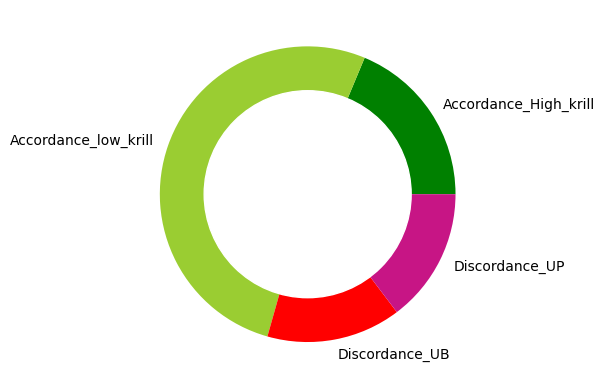

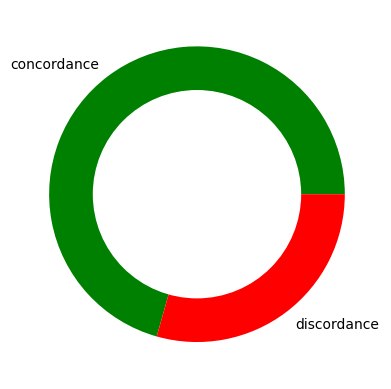

concordance_type
Accordance_High_krill    196
Accordance_low_krill     544
Discordance_UB           154
Discordance_UP           154
Name: count, dtype: int64

In [294]:
# count each type
counts = (
    krill_common_range
    .sort_values(by='concordance_type')
    ['concordance_type']
    .value_counts()
    .sort_index()  # Tri selon l’ordre numérique des catégories
)
counts

counts.plot.pie(colors = ['green', 'yellowgreen', 'red', 'mediumvioletred'], ylabel='')#, colors=['navajowhite', 'thistle', 'indianred', 'red', 'blue', 'green', 'yellow', 'black'])

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# plt.savefig('./figures/donut_krilltiertile_KP_vs_KB_common_range.png', bbox_inches = 'tight', dpi=300)

plt.show()

krill_data['concordance_yes_no'].value_counts().plot.pie(labels=['concordance', 'discordance'], colors = ['green', 'red'], ylabel='')
# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

display(counts)

In [228]:
concordance_xarray = xr.Dataset.from_dataframe(krill_common_range[['concordance_type_nb']])
concordance_xarray

<xarray.Dataset>
Dimensions:              (latitude: 16, longitude: 179)
Coordinates:
  * latitude             (latitude) int64 -77 -75 -73 -71 ... -53 -51 -49 -47
  * longitude            (longitude) int64 -179 -177 -175 -173 ... 173 175 177
Data variables:
    concordance_type_nb  (latitude, longitude) float64 nan nan nan ... nan nan

In [229]:
krill_common_range['concordance_type_nb'].unique()

array([2, 3, 4, 1], dtype=int64)

Text(0.5, 1.0, '')

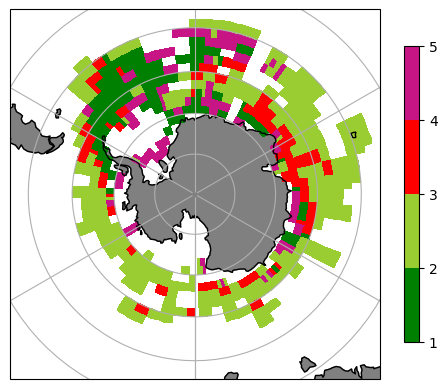

In [230]:
map_proj = ccrs.SouthPolarStereo()

p = concordance_xarray["concordance_type_nb"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[1, 2, 3, 4, 5], 
    colors = ['green', 'yellowgreen', 'red', 'mediumvioletred'] #,'purple', 'thistle']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, shrink = 0.8)
plt.title('')

### Them if we want the comparison on the whole KP range, we have to add the data that are in KP but not KB.
> **However, the status (lower 2/3 or upper 1/3) is defined with titertile on the WHOLE KP dataset...**
So we acolate in the same map, cell that were not identifiy with the same calculation of the the tiertiles...
> Possible to add just the addtional cells from KP **without giving their stauts**: they are all "uncertain" bc only KP outputs, no KB data.

In [253]:
krillpodym_copy = krill_podym.copy()
krillpodym_copy['grid'] = 1
krillpodym_copy = krillpodym_copy[['grid']]

# merge krill_common_range with krill_podym, how = right to add the cells from KP not in KB
krill_common_range_extended = krill_common_range.merge(krillpodym_copy, how='right', 
                                                       left_index=True, right_index=True) # this will create NAN in cells outside of the common range

# fill nan in the columns
krill_common_range_extended['concordance_type'].fillna("no_data_in_KB", inplace=True)
krill_common_range_extended['concordance_type_nb'].fillna(0, inplace=True)
krill_common_range_extended['concordance_yes_no'].fillna(-1, inplace=True)

In [254]:
krill_common_range_extended

STANDARDISED_KRILL_UNDER_1M2_log  UpTiertile_B  \
latitude longitude                                                   
-77      -179                                    NaN           NaN   
         -177                                    NaN           NaN   
         -175                                    NaN           NaN   
         -173                                    NaN           NaN   
         -171                                    NaN           NaN   
...                                              ...           ...   
-45       63                                     NaN           NaN   
          65                                     NaN           NaN   
          67                                     NaN           NaN   
          69                                     NaN           NaN   
          71                                     NaN           NaN   

                    krill_adult_log  UpTiertile_P concordance_type  \
latitude longitude                                                   
-77      -179                   NaN           NaN    no_data_in_KB   
         -177                   NaN           NaN    no_data_in_KB   
         -175                   NaN           NaN    no_data_in_KB   
         -173                   NaN           NaN    no_data_in_KB   
         -171                   NaN           NaN    no_data_in_KB   
...                             ...           ...              ...   
-45       63                    NaN           NaN    no_data_in_KB   
          65                    NaN           NaN    no_data_in_KB   
          67                    NaN           NaN    no_data_in_KB   
          69                    NaN           NaN    no_data_in_KB   
          71                    NaN           NaN    no_data_in_KB   

                    concordance_type_nb  concordance_yes_no  grid  
latitude longitude                                                 
-77      -179                       0.0                -1.0     1  
         -177                       0.0                -1.0     1  
         -175                       0.0                -1.0     1  
         -173                       0.0                -1.0     1  
         -171                       0.0                -1.0     1  
...                                 ...                 ...   ...  
-45       63                        0.0                -1.0     1  
          65                        0.0                -1.0     1  
          67                        0.0                -1.0     1  
          69                        0.0                -1.0     1  
          71                        0.0                -1.0     1  

[1890 rows x 8 columns]

concordance_type
Accordance_High_krill    196
Accordance_low_krill     544
Discordance_UB           154
Discordance_UP           154
no_data_in_KB            842
Name: count, dtype: int64

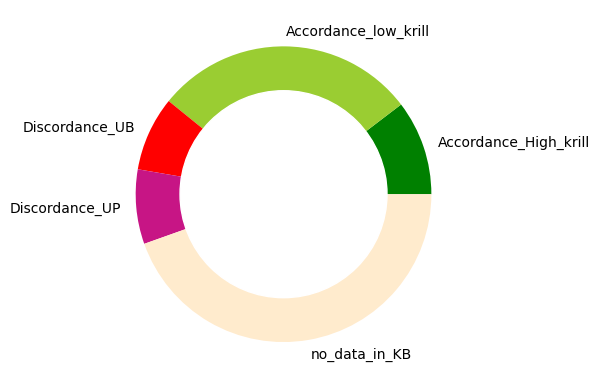

In [300]:
## Donut plot 
counts2 = (
    krill_common_range_extended
    .sort_values(by='concordance_type')
    ['concordance_type']
    .value_counts()
    .sort_index()  # Tri selon l’ordre numérique des catégories
)
counts2

counts2.plot.pie(colors = [ 'green', 'yellowgreen', 'red', 'mediumvioletred', 'blanchedalmond'], ylabel='')#, colors=['navajowhite', 'thistle', 'indianred', 'red', 'blue', 'green', 'yellow', 'black'])

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# plt.savefig('./figures/donut_krilltiertile_KP_vs_KB_common_range2.png', bbox_inches = 'tight', dpi=300)

plt.show()

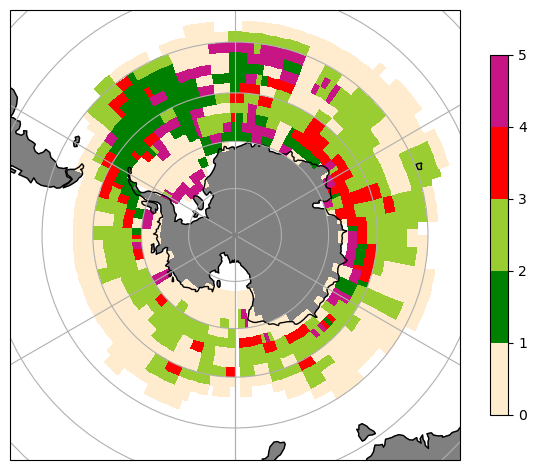

In [275]:
concordance_xarray = xr.Dataset.from_dataframe(krill_common_range_extended[['concordance_type_nb']])
concordance_xarray

map_proj = ccrs.SouthPolarStereo()

p = concordance_xarray["concordance_type_nb"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[0, 1, 2, 3, 4, 5], 
    colors = ['blanchedalmond', 'green', 'yellowgreen', 'red', 'mediumvioletred']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, shrink = 0.8)
plt.title('')

plt.tight_layout()
# plt.savefig('./figures/krilltiertile_KP_vs_KB_common_range.png', bbox_inches = 'tight', dpi=300)

plt.show()

# Comparision between KRILLBASE and KRILLPODYM over their whole own spatial range

## Extract the upper tier-tile for both distributions and compare

In [195]:
krill_podym_quantiles = krill_podym['krill_adult_log'].quantile(q=[0.3333, 0.6666])
krill_base_quantiles = krill_base['STANDARDISED_KRILL_UNDER_1M2_log'].quantile(q=[0.3333, 0.6666])
display(krill_podym.quantile(q=[0.3333, 0.6666]))
display(krill_base.quantile(q=[0.3333, 0.6666]))

,krill_adult_log
0.3333,1.09418
0.6666,1.59819


,STANDARDISED_KRILL_UNDER_1M2_log
0.3333,0.020672
0.6666,0.693444


### Extract the upper tiertile of krillpodym and krillbase 

In [196]:
krill_podym['UpTiertile_P'] = np.where(krill_podym['krill_adult_log'] > krill_podym_quantiles.iloc[1], 1, 0)
krill_base['UpTiertile_B'] = np.where(krill_base['STANDARDISED_KRILL_UNDER_1M2_log'] > krill_base_quantiles.iloc[1], 1, 0)

In [197]:
krill_data = krill_podym.merge(krill_base, how='left', left_index=True, right_index=True)
krill_data

krill_adult_log  UpTiertile_P  \
latitude longitude                                  
-77      -179               0.57452             0   
         -177               0.81818             0   
         -175               1.00264             0   
         -173               0.99747             0   
         -171               1.14972             0   
...                             ...           ...   
-45       63                0.00001             0   
          65                0.00762             0   
          67                0.10288             0   
          69                0.05762             0   
          71                0.00012             0   

                    STANDARDISED_KRILL_UNDER_1M2_log  UpTiertile_B  
latitude longitude                                                  
-77      -179                                    NaN           NaN  
         -177                                    NaN           NaN  
         -175                                    NaN           NaN  
         -173                                    NaN           NaN  
         -171                                    NaN           NaN  
...                                              ...           ...  
-45       63                                     NaN           NaN  
          65                                     NaN           NaN  
          67                                     NaN           NaN  
          69                                     NaN           NaN  
          71                                     NaN           NaN  

[1890 rows x 4 columns]

In [198]:
krill_data_xarray = xr.Dataset.from_dataframe(krill_data)
krill_data_xarray

<xarray.Dataset>
Dimensions:                           (latitude: 17, longitude: 179)
Coordinates:
  * latitude                          (latitude) int64 -77 -75 -73 ... -47 -45
  * longitude                         (longitude) int64 -179 -177 ... 175 177
Data variables:
    krill_adult_log                   (latitude, longitude) float64 0.5745 .....
    UpTiertile_P                      (latitude, longitude) float64 0.0 ... nan
    STANDARDISED_KRILL_UNDER_1M2_log  (latitude, longitude) float64 nan ... nan
    UpTiertile_B                      (latitude, longitude) float64 nan ... nan

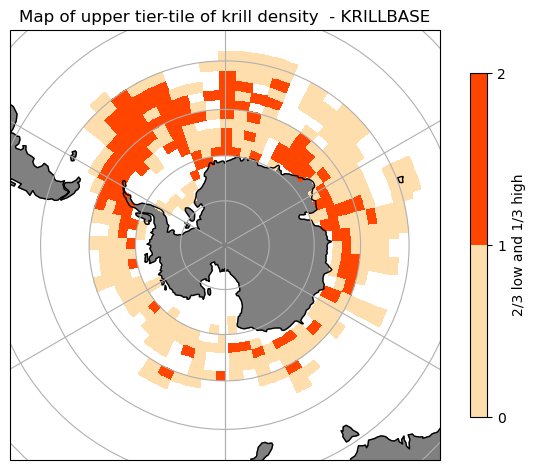

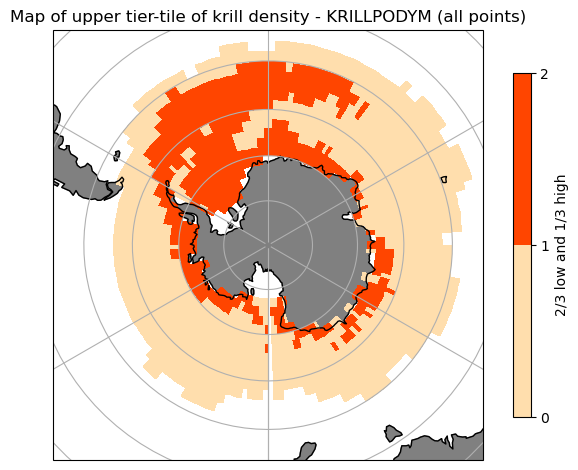

In [273]:
map_proj = ccrs.SouthPolarStereo()

p = krill_data_xarray["UpTiertile_B"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels = [0, 1,2],
    colors = ['navajowhite', 'orangered']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = '2/3 low and 1/3 high', shrink = 0.8)
plt.title('Map of upper tier-tile of krill density  - KRILLBASE')
plt.tight_layout()
# plt.savefig('./figures/upper_tiertile_KB.png', bbox_inches = 'tight', dpi=300)

plt.show()



map_proj = ccrs.SouthPolarStereo()

p = krill_data_xarray["UpTiertile_P"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels = [0, 1, 2],
    colors = ['navajowhite', 'orangered']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = '2/3 low and 1/3 high', shrink = 0.8)
plt.title('Map of upper tier-tile of krill density - KRILLPODYM (all points)')
plt.tight_layout()
# plt.savefig('./figures/upper_tiertile_KP_all_range.png', bbox_inches = 'tight', dpi=300)

## Find concordant and discordant cells betwwen the two datasets

In [200]:
conditions = [
    (krill_data["UpTiertile_P"] == 1) & (krill_data["UpTiertile_B"] == 1),
    (krill_data["UpTiertile_P"] == 0) & (krill_data["UpTiertile_B"] == 0),
    
    (krill_data["UpTiertile_P"] == 0) & (krill_data["UpTiertile_B"] == 1),
    (krill_data["UpTiertile_P"] == 1) & (krill_data["UpTiertile_B"] == 0),

    (krill_data["UpTiertile_P"] == 1) & (krill_data["UpTiertile_B"].isna()),
    (krill_data["UpTiertile_P"] == 0) & (krill_data["UpTiertile_B"].isna()),

    (krill_data["UpTiertile_P"].isna()) & (krill_data["UpTiertile_B"] == 1),
    (krill_data["UpTiertile_P"].isna()) & (krill_data["UpTiertile_B"] == 0),

]

values = ["1", "2", 
          "3", "4",
         "5", "6",
         "7", "8"]

values_cat = ["Accordance_High_krill", "Accordance_low_krill", 
          "Discordance_UB", "Discordance_UP",
         "No_data_KB_highkrill", "No_data_KB_low_krill",
         "No_data_KP_highkrill", "No_data_KP_lowkrill"]


krill_data['concordance_type'] = np.select(conditions, values_cat)
krill_data['concordance_type_nb'] = np.select(conditions, values)

krill_data["concordance_type_nb"] = pd.to_numeric(krill_data["concordance_type_nb"])
                                 
krill_data

krill_adult_log  UpTiertile_P  \
latitude longitude                                  
-77      -179               0.57452             0   
         -177               0.81818             0   
         -175               1.00264             0   
         -173               0.99747             0   
         -171               1.14972             0   
...                             ...           ...   
-45       63                0.00001             0   
          65                0.00762             0   
          67                0.10288             0   
          69                0.05762             0   
          71                0.00012             0   

                    STANDARDISED_KRILL_UNDER_1M2_log  UpTiertile_B  \
latitude longitude                                                   
-77      -179                                    NaN           NaN   
         -177                                    NaN           NaN   
         -175                                    NaN           NaN   
         -173                                    NaN           NaN   
         -171                                    NaN           NaN   
...                                              ...           ...   
-45       63                                     NaN           NaN   
          65                                     NaN           NaN   
          67                                     NaN           NaN   
          69                                     NaN           NaN   
          71                                     NaN           NaN   

                        concordance_type  concordance_type_nb  
latitude longitude                                             
-77      -179       No_data_KB_low_krill                    6  
         -177       No_data_KB_low_krill                    6  
         -175       No_data_KB_low_krill                    6  
         -173       No_data_KB_low_krill                    6  
         -171       No_data_KB_low_krill                    6  
...                                  ...                  ...  
-45       63        No_data_KB_low_krill                    6  
          65        No_data_KB_low_krill                    6  
          67        No_data_KB_low_krill                    6  
          69        No_data_KB_low_krill                    6  
          71        No_data_KB_low_krill                    6  

[1890 rows x 6 columns]

In [201]:
conditions = [
    (krill_data['concordance_type'] == "Accordance_High_krill") | (krill_data['concordance_type'] == "Accordance_low_krill"),
    (krill_data['concordance_type'] == "Discordance_UP") | (krill_data['concordance_type'] == "Discordance_UB")
]

values = [1, 0]

krill_data['concordance_yes_no'] = np.select(conditions, values, default=np.NaN)
krill_data

krill_adult_log  UpTiertile_P  \
latitude longitude                                  
-77      -179               0.57452             0   
         -177               0.81818             0   
         -175               1.00264             0   
         -173               0.99747             0   
         -171               1.14972             0   
...                             ...           ...   
-45       63                0.00001             0   
          65                0.00762             0   
          67                0.10288             0   
          69                0.05762             0   
          71                0.00012             0   

                    STANDARDISED_KRILL_UNDER_1M2_log  UpTiertile_B  \
latitude longitude                                                   
-77      -179                                    NaN           NaN   
         -177                                    NaN           NaN   
         -175                                    NaN           NaN   
         -173                                    NaN           NaN   
         -171                                    NaN           NaN   
...                                              ...           ...   
-45       63                                     NaN           NaN   
          65                                     NaN           NaN   
          67                                     NaN           NaN   
          69                                     NaN           NaN   
          71                                     NaN           NaN   

                        concordance_type  concordance_type_nb  \
latitude longitude                                              
-77      -179       No_data_KB_low_krill                    6   
         -177       No_data_KB_low_krill                    6   
         -175       No_data_KB_low_krill                    6   
         -173       No_data_KB_low_krill                    6   
         -171       No_data_KB_low_krill                    6   
...                                  ...                  ...   
-45       63        No_data_KB_low_krill                    6   
          65        No_data_KB_low_krill                    6   
          67        No_data_KB_low_krill                    6   
          69        No_data_KB_low_krill                    6   
          71        No_data_KB_low_krill                    6   

                    concordance_yes_no  
latitude longitude                      
-77      -179                      NaN  
         -177                      NaN  
         -175                      NaN  
         -173                      NaN  
         -171                      NaN  
...                                ...  
-45       63                       NaN  
          65                       NaN  
          67                       NaN  
          69                       NaN  
          71                       NaN  

[1890 rows x 7 columns]

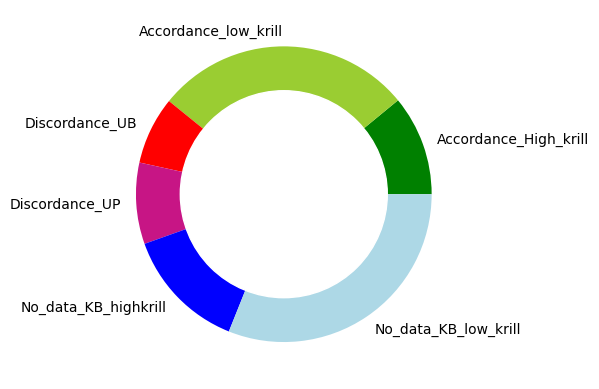

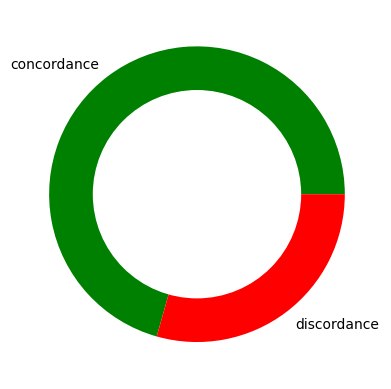

concordance_type
Accordance_High_krill    207
Accordance_low_krill     533
Discordance_UB           140
Discordance_UP           168
No_data_KB_highkrill     255
No_data_KB_low_krill     587
Name: count, dtype: int64

In [280]:
# count each type
counts = (
    krill_data
    .sort_values(by='concordance_type')
    ['concordance_type']
    .value_counts()
    .sort_index()  # Tri selon l’ordre numérique des catégories
)
counts

counts.plot.pie(colors = ['green', 'yellowgreen', 'red', 'mediumvioletred','blue',  'lightblue'],  ylabel='' )

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# plt.savefig('./figures/donut_krilltiertile_KP_vs_KB_all_range.png', bbox_inches = 'tight', dpi=300)

plt.show()

krill_data['concordance_yes_no'].value_counts().plot.pie(labels=['concordance', 'discordance'], colors = ['green', 'red'], ylabel='' )
# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# plt.savefig('./figures/donut_krilltiertile_KP_vs_KB_all_range2.png', bbox_inches = 'tight', dpi=300)

plt.show()

display(counts)

### Plot cells that are in the upper tiertile of one or both datasets

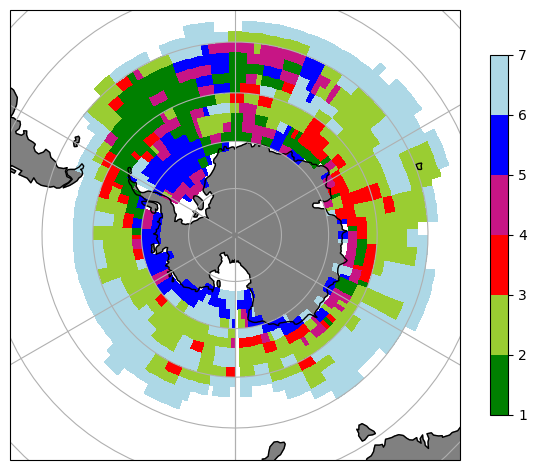

TypeError: 'NoneType' object is not callable

In [272]:
concordance_xarray = xr.Dataset.from_dataframe(krill_data[['concordance_type_nb']])
concordance_xarray

map_proj = ccrs.SouthPolarStereo()

p = concordance_xarray["concordance_type_nb"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[1, 2, 3, 4, 5, 6, 7], 
    colors = ['green', 'yellowgreen', 'red', 'mediumvioletred', 'blue',  'lightblue'] #,'purple', 'thistle']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, shrink = 0.8)
plt.title('')

plt.tight_layout()

# plt.savefig('./figures/krilltiertile_KP_vs_KB_all_range.png', bbox_inches = 'tight', dpi=300)
plt.show()